<a href="https://colab.research.google.com/github/aserravalle/Transfer_Learning_Radiology_Classifier/blob/master/Transfer_Learning_Radiology_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models.

This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

# Requirements

Must upload onto colab:
*   your Kaggle API
*   your single test image titled 'image.jpg'



# Setup

In [0]:
!pip install -U tensorflow_hub

In [0]:
import numpy as np
import PIL.Image as Image

# What do these do??
from __future__ import absolute_import, division, print_function, unicode_literals

# Plotting
import matplotlib.pylab as plt

# Share pretrained model components
import tensorflow_hub as hub

# Machine learning
from tensorflow.keras import layers
import tensorflow as tf
tf.enable_eager_execution()

# Original Classifier

In [0]:
# Download pretrained mobilenet classifier
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

# Training parameters
IMAGE_SHAPE = (224, 224)

# Add layers to the model with Sequential() function
    # Call the above model with hub module
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape = IMAGE_SHAPE + (3,) )
])

In [0]:
# Get a single image for testing
test_img = Image.open("/content/image.jpg").resize(IMAGE_SHAPE)
test_img

# Remodel as array
test_img = np.array(test_img)/255.0
print('input shape = ',test_img.shape, ', 255x255 RGB pixels')

# Get the probabilities of each class in the mobilenet classifier
probs = classifier.predict(test_img[np.newaxis, ...])
print('output shape = ',probs.shape,', a probability for each 1001 class')

# Find the label of the prediction
predicted_class = np.argmax(probs[0], axis=-1)
print('prediction index = ',predicted_class)

# Get the class names from MobileNet indexes 
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_name = imagenet_labels[predicted_class]

# Show the image with a prediction
plt.imshow(test_img)
plt.axis('off')
_ = plt.title("Prediction: " + predicted_class_name.title())

# Lung Scan Dataset

In [42]:
# Load the lung scan data from Kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 98% 1.13G/1.15G [00:29<00:00, 25.5MB/s]
100% 1.15G/1.15G [00:29<00:00, 42.2MB/s]


In [59]:
import zipfile

# Extract first zip file
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall("/content/")
zip_ref.close()

# ... the second
zip_ref = zipfile.ZipFile('/content/chest_xray.zip', 'r')
zip_ref.extractall("/content")
zip_ref.close()

data_path = '/content/chest_xray/train'
print(data_path)

/content/chest_xray/train


In [62]:
# Load the data using keras preprocessing
    # Must be nested in data/train/class/img folders
    # Can rescale to 1x1 shape using rescale option
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(data_path, target_size=IMAGE_SHAPE)

# Show the batch sizes we will work with
for image_batch, label_batch in image_data:
    print('Batch size = 32')
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

# The resulting object is an iterator that returns image_batch, label_batch pairs

Found 5216 images belonging to 2 classes.
Batch size = 32
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [0]:
# Run the predictions on the first batch of 32 images
result_batch = classifier.predict(image_batch)
print(result_batch.shape)

# Return their predicted classes
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
print(predicted_class_names)

In [0]:
# View the predictions alongside images
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Transfer Learning

In [0]:
# Extract the MobileNet classifier as a headless model
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

# Show that headless NNs output a raw array (instead of a single prediction)
feature_batch = feature_extractor_layer(image_batch)
print('Headless layer :',feature_batch.shape) # 1280-element vector per image

# Stop the model from training previous layers of NN
feature_extractor_layer.trainable = False

# Attach classification head
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax') # Add a new condensing layer to get the predictions
])

# Get predictions
predictions = model(image_batch)
print('Transfer layer :',predictions.shape) # 2 probabilities for each image in the batch

model.summary()

## Training

In [0]:
#  Log the loss and accuracy of each batch using custom callback
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()
    
# Configure the training process
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback = CollectBatchStats()

In [0]:
# Fit the model
history = model.fit(image_data, epochs=2, # Only did 2 epochs to keep training short
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## Re-attempt previous predictions

In [0]:
# Get the class names
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

# Make predictions
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

# Plot the results
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Evaluate on Validation Data

Found 16 images belonging to 2 classes.
['Normal' 'Pneumonia']
Batch size = 32
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


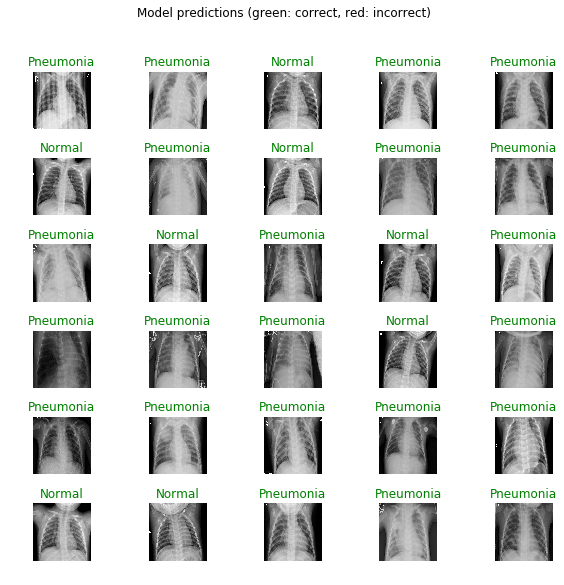

In [94]:
# Load validation dataset
data_path_val = '/content/chest_xray/val'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data_val = image_generator.flow_from_directory(data_path_val, target_size=IMAGE_SHAPE)

# Get the class names
class_names = sorted(image_data_val.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
print(class_names)

# Get the image and label batch
for image_batch, label_batch in image_data:
    print('Batch size = 32')
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

# Make predictions
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

# Plot the results
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

COOL the model works

# Export Model

In [0]:
import time
t = time.time()

export_path = "/content/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

## Confirm Saving

In [0]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [0]:
abs(reloaded_result_batch - result_batch).max()

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

